In [2]:
import pandas as pd
import numpy as np

df_movies = pd.read_csv('ml-20m/movies.csv')
df_ratings = pd.read_csv('ml-20m/ratings.csv')

movieId_to_name = pd.Series(df_movies.title.values, 
                            index = df_movies.movieId.values).to_dict()
name_to_movieId = pd.Series(df_movies.movieId.values, 
                            index = df_movies.title).to_dict()

# Randomly display 5 records in the dataframe
for df in list((df_movies, df_ratings)):
    rand_idx = np.random.choice(len(df), 5, replace=False)
    display(df.iloc[rand_idx,:])
    print("Displaying 5 of the total "+str(len(df))+" data points")

movieId                                              title  \
5015      5111                               Good Son, The (1993)   
10003    32906                Ascent, The (Voskhozhdeniye) (1977)   
16509    83381                               Seven Thieves (1960)   
846        861  Supercop (Police Story 3: Supercop) (Jing cha ...   
20155    99258  Who Wants to Kill Jessie? (Kdo chce zabít Jess...   

                             genres  
5015                 Drama|Thriller  
10003                     Drama|War  
16509                   Crime|Drama  
846    Action|Comedy|Crime|Thriller  
20155                 Comedy|Sci-Fi

Displaying 5 of the total 27278 data points


userId  movieId  rating   timestamp
7937017    54688    47610     3.5  1370061037
11079211   76564     1101     3.0   946438936
15516997  107317     1270     0.5  1162693457
17771935  122871     5313     3.5  1230660174
16371933  113342      780     3.0  1356738841

Displaying 5 of the total 20000263 data points


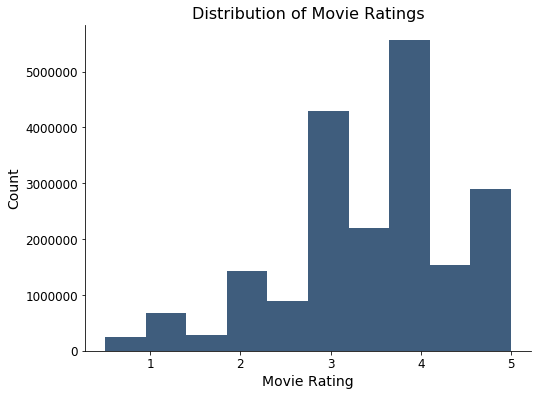

In [3]:
import matplotlib.pyplot as plt
import plotly.plotly as py
%matplotlib inline

plt.figure(figsize=(8, 6))
ax = plt.subplot(111)
ax.set_title("Distribution of Movie Ratings", fontsize=16)
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)  
  
plt.xticks(fontsize=12)  
plt.yticks(fontsize=12)  
  
plt.xlabel("Movie Rating", fontsize=14)  
plt.ylabel("Count", fontsize=14)  
  
plt.hist(df_ratings['rating'], color="#3F5D7D")  

plt.show()

In [4]:
from sklearn.model_selection import train_test_split

df_ratings_train, df_ratings_test= train_test_split(df_ratings,
                                                    stratify=df_ratings['userId'],
                                                    random_state = 15688,
                                                    test_size=0.30)

In [5]:
print("Number of training data: "+str(len(df_ratings_train)))
print("Number of test data: "+str(len(df_ratings_test)))

Number of training data: 14000184
Number of test data: 6000079


In [6]:
def rating_splitter(df):
    
    df['liked'] = np.where(df['rating']>=4, 1, 0)
    df['movieId'] = df['movieId'].astype('str')
    gp_user_like = df.groupby(['liked', 'userId'])

    return ([gp_user_like.get_group(gp)['movieId'].tolist() for gp in gp_user_like.groups])

In [7]:
pd.options.mode.chained_assignment = None
splitted_movies = rating_splitter(df_ratings_train)

In [8]:
import warnings
warnings.filterwarnings(action='ignore', category=UserWarning, module='gensim')

import gensim
assert gensim.models.word2vec.FAST_VERSION > -1

The below code shuffles the training data:

In [19]:
import random

for movie_list in splitted_movies:
    random.shuffle(movie_list)

In [55]:
from gensim.models import Word2Vec
import datetime
start = datetime.datetime.now()

model = Word2Vec(sentences = splitted_movies, # We will supply the pre-processed list of moive lists to this parameter
                 iter = 5, # epoch
                 min_count = 10, # a movie has to appear more than 10 times to be keeped
                 size = 200, # size of the hidden layer
                 workers = 4, # specify the number of threads to be used for training
                 sg = 1, # Defines the training algorithm. We will use skip-gram so 1 is chosen.
                 hs = 0, # Set to 0, as we are applying negative sampling.
                 negative = 5, # If > 0, negative sampling will be used. We will use a value of 5.
                 window = 9999999)

print("Time passed: " + str(datetime.datetime.now()-start))
#Word2Vec.save('item2vec_20180327')

Time passed: 2:12:26.134283


In [40]:
from gensim.models import Word2Vec
import datetime
start = datetime.datetime.now()

model_w2v_sg = Word2Vec(sentences = splitted_movies,
                        iter = 10, # epoch
                        min_count = 5, # a movie has to appear more than 5 times to be keeped
                        size = 300, # size of the hidden layer
                        workers = 4, # specify the number of threads to be used for training
                        sg = 1,
                        hs = 0,
                        negative = 5,
                        window = 9999999)

print("Time passed: " + str(datetime.datetime.now()-start))
model_w2v_sg.save('item2vec_word2vecSg_20180328')
del model_w2v_sg

Time passed: 5:32:50.270232


In [16]:
import warnings
warnings.filterwarnings(action='ignore', category=UserWarning, module='gensim')

from gensim.models import Word2Vec
model = Word2Vec.load('item2vec_20180327')
word_vectors = model.wv
# del model # uncomment this line will delete the model

In [17]:
import requests
import re
from bs4 import BeautifulSoup

def refine_search(search_term):
    """
    Refine the movie name to be recognized by the recommender
    Args:
        search_term (string): Search Term

    Returns:
        refined_term (string): a name that can be search in the dataset
    """
    target_url = "http://www.imdb.com/find?ref_=nv_sr_fn&q="+"+".join(search_term.split())+"&s=tt"
    html = requests.get(target_url).content
    parsed_html = BeautifulSoup(html, 'html.parser')
    for tag in parsed_html.find_all('td', class_="result_text"):
        search_result = re.findall('fn_tt_tt_1">(.*)</a>(.*)</td>', str(tag))
        if search_result:
            if search_result[0][0].split()[0]=="The":
                str_frac = " ".join(search_result[0][0].split()[1:])+", "+search_result[0][0].split()[0]
                refined_name = str_frac+" "+search_result[0][1].strip()
            else:
                refined_name = search_result[0][0]+" "+search_result[0][1].strip()
    return refined_name

def produce_list_of_movieId(list_of_movieName, useRefineSearch=False):
    """
    Turn a list of movie name into a list of movie ids. The movie names has to be exactly the same as they are in the dataset.
    Ambiguous movie names can be supplied if useRefineSearch is set to True
    
    Args:
        list_of_movieName (List): A list of movie names.
        useRefineSearch (boolean): Ambiguous movie names can be supplied if useRefineSearch is set to True

    Returns:
        list_of_movie_id (List of strings): A list of movie ids.
    """
    list_of_movie_id = []
    for movieName in list_of_movieName:
        if useRefineSearch:
            movieName = refine_search(movieName)
            print("Refined Name: "+movieName)
        if movieName in name_to_movieId.keys():
            list_of_movie_id.append(str(name_to_movieId[movieName]))
    return list_of_movie_id

def recommender(positive_list=None, negative_list=None, useRefineSearch=False, topn=20):
    recommend_movie_ls = []
    if positive_list:
        positive_list = produce_list_of_movieId(positive_list, useRefineSearch)
    if negative_list:
        negative_list = produce_list_of_movieId(negative_list, useRefineSearch)
    for movieId, prob in model.wv.most_similar_cosmul(positive=positive_list, negative=negative_list, topn=topn):
        recommend_movie_ls.append(movieId)
    return recommend_movie_ls

In [18]:
ls = recommender(positive_list=["UP"], useRefineSearch=True, topn=5)
print('Recommendation Result based on "Up (2009)":')
display(df_movies[df_movies['movieId'].isin(ls)])

Refined Name: Up (2009)
Recommendation Result based on "Up (2009)":


movieId                            title  \
11614    50872               Ratatouille (2007)   
12746    60069                    WALL·E (2008)   
14592    72998                    Avatar (2009)   
15031    76093  How to Train Your Dragon (2010)   
15401    78499               Toy Story 3 (2010)   

                                                 genres  
11614                          Animation|Children|Drama  
12746       Adventure|Animation|Children|Romance|Sci-Fi  
14592                      Action|Adventure|Sci-Fi|IMAX  
15031         Adventure|Animation|Children|Fantasy|IMAX  
15401  Adventure|Animation|Children|Comedy|Fantasy|IMAX

In [20]:
ls = recommender(positive_list=["The Matrix", "Django Unchained"], useRefineSearch=True, topn=7)
print('Recommendation Result based on "The Matrix (1999)" + ""Django Unchained (2012)":')
display(df_movies[df_movies['movieId'].isin(ls)])

Refined Name: Matrix, The (1999)
Refined Name: Django Unchained (2012)
Recommendation Result based on "The Matrix (1999)" + ""Django Unchained (2012)":


movieId                          title  \
11401    48780           Prestige, The (2006)   
12525    58559        Dark Knight, The (2008)   
13102    63082     Slumdog Millionaire (2008)   
13647    68157    Inglourious Basterds (2009)   
14009    70286              District 9 (2009)   
15534    79132               Inception (2010)   
18312    91529  Dark Knight Rises, The (2012)   

                                                genres  
11401                    Drama|Mystery|Sci-Fi|Thriller  
12525                          Action|Crime|Drama|IMAX  
13102                              Crime|Drama|Romance  
13647                                 Action|Drama|War  
14009                          Mystery|Sci-Fi|Thriller  
15534  Action|Crime|Drama|Mystery|Sci-Fi|Thriller|IMAX  
18312                      Action|Adventure|Crime|IMAX